# Introducción a la predicción de series temporales
Las series de tiempo son diferentes de los problemas de modelado predictivo de regresión y clasificación más tradicionales. La estructura temporal agrega un orden a las observaciones. Este orden impuesto significa que los supuestos importantes sobre la coherencia de esas observaciones deben manejarse específicamente.
El objetivo de la predicción de series temporales es realizar predicciones precisas sobre el futuro. En este Jupyter Notebook, nos centraremos en cómo realizar predicciones sobre problemas de series de tiempo univariadas utilizando las herramientas estándar del ecosistema Python. La librería Pandas en Python proporciona un excelente soporte integrado para datos de series de tiempo, mientras que Statsmodels es un módulo de Python que permite a los usuarios explorar datos, estimar modelos estadísticos y realizar pruebas estadísticas.

Descargue el conjunto de datos de Tasas de fondos federales efectivas del [sitio web de datos económicos de FRED](https://fred.stlouisfed.org/series/FEDFUNDS). La tasa de fondos federales es la tasa de interés a la que las instituciones de depósito intercambian fondos federales entre sí durante la noche. Nos centraremos en pronosticar los tipos de interés hasta la crisis financiera de 2008.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Data


<h3 id="Load-and-Explore-Time-Series-Data">Load and Explore Time Series Data<a class="anchor-link" href="#Load-and-Explore-Time-Series-Data">¶</a></h3>


In [ ]:
# load dataset
dataframe = pd.read_csv('FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )

In [ ]:
# display first few lines of a time series
dataframe.head()


<h4 id="Create-Time-Series">Create Time Series<a class="anchor-link" href="#Create-Time-Series">¶</a></h4><p>Pandas represents time series datasets as a Series. A Series is a one-dimensional array with a time label for each row.</p>


In [ ]:
# create a time series
s = pd.Series(dataframe.unstack().values, index=dataframe.index)

In [ ]:
# basic plot
s.plot();

### Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components

- **Systematic**: Components of the time series that have consistency or recurrence and can
be described and modeled.
- **Non-Systematic**: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level,
trend, seasonality, and one non-systematic component called noise. These components are
defined as follows:

- **Level**: The average value in the series.
- **Trend**: The increasing or decreasing value in the series.
- **Seasonality**: The repeating short-term cycle in the series.
- **Noise**: The random variation in the series.

Our time series dataset may contain a trend. A trend is a continued increase or decrease in
the series over time. There can be benefit in identifying, modeling, and even removing trend
information from your time series dataset.
Time series datasets can contain a seasonal component. This is a cycle that repeats over time,
such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model
when forecasting, and in turn may provide a strong signal to our predictive models. There are many types of seasonality: time of day, daily, weekly, monthly, yearly etc. Identifying whether there is a seasonality component in your time series problem is
subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

A time series where the seasonal component has been removed is called **seasonal stationary**. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be **trend stationary**.


### Stationarity in Time Series Data

The observations in a stationary time series are not dependent on time. Time series are stationary
if they do not have trend or seasonal effects. Summary statistics calculated on the time series
are consistent over time, like the mean or the variance of the observations. When a time series
is stationary, it can be easier to model. Statistical modeling methods assume or require the
time series to be stationary to be effective.</p>


#### Check for Stationarity
There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

- **Look at Plots**: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
- **Summary Statistics**: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
- **Statistical Tests**: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

In [ ]:
s.plot();

#### Augmented-Dickey-Fuller-test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [ ]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

We can see that our statistic value of -3.185 is less than the value of -2.866 at 5%. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

## Evaluate-Models

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using *train-test splits* and *k-fold cross-validation*, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.
In time series forecasting, this evaluation of models on historical data is called **backtesting**. We will look at three different methods that you can use to backtest your machine learning models on time series problems:

- **Train-Test split** that respects temporal order of observations.
- **Multiple Train-Test splits** that respect temporal order of observations.
- **Walk-Forward Validation** where a model may be updated each time step new data is received.

### Train-Test Split

In [ ]:
# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [ ]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

### Multiple Train-Test Splits
We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the train-split tests with different split points.

The scikit-learn library provides a time series "cross-validator" in the `TimeSeriesSplit` module. It provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [ ]:
# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 

Using multiple train-test splits will result in more models being trained, and in turn, a
more accurate estimate of the performance of the models on unseen data. A limitation of the
train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available.

### Walk Forward Validation

In practice, we very likely will retrain our model as new data becomes available. This would
give the model the best opportunity to make good forecasts at each time step.
There are few decisions to make:

- **Minimum Number of Observations**. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
- **Sliding or Expanding Window**. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

In [ ]:
# walk forward validation: the train set expanding each time step
# and the test set fixed at one time step ahead
X = s[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

### Persistence Model for Forecasting
Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. Here we will develop a persistence forecast that we can use later as a baseline level of performance on this time series dataset.
The following steps are required:

- Transform the univariate dataset into a supervised learning problem.
- Establish the train and test datasets for the test harness.
- Define the persistence model.
- Make a forecast and establish a baseline performance.
- Review the complete example and plot the output.

In [ ]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
# persistence model
def model_persistence(x):
    return x

In [ ]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [ ]:
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions]);

### Visualize Residual Forecast Errors

Forecast errors on a time series forecasting problem are called <em>residual errors</em> or <em>residuals</em>. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.</p>


In [ ]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)


<p>The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure.</p>


In [ ]:
# plot residuals
residuals.plot();


<p>We can calculate summary statistics on the residual errors. Primarily, we are interested in
the mean value of the residual errors. A value close to zero suggests no bias in the forecasts,
whereas positive and negative values suggest a positive or negative bias in the forecasts made.
It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior
to their use or evaluation.</p>


In [ ]:
residuals.describe()

Plots can be used to better understand the distribution of errors beyond summary statistics.
We would expect the forecast errors to be normally distributed around a zero mean.

In [ ]:
# histograms plot
residuals.hist();

In [ ]:
# density plot
residuals.plot(kind='kde');

#### Residual Q-Q Plot
A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.</p>


In [ ]:
qqplot(residuals, line='r')
plt.show()

#### Residual Autocorrelation Plot

We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being
below the threshold of significance (dashed and dotted horizontal lines on the plot). A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called <em>autoregression</em>.


In [ ]:
autocorrelation_plot(residuals);

In [ ]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()

### Reframe Time Series Forecasting Problems
There are many ways to reframe the forecast problem that can both simplify the prediction problem and potentially
expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts.</p>


### Classification Framings
Classification involves predicting categorical or label outputs (such as <em>high</em>, <em>medium</em>, and <em>low</em>). For example, we can forecast whether a change in minimum value will be small or large, or whether the new value will be lower or higher than the current value.

In [ ]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
def make_discrete(row):
   if row['t+1'] < 0:
      return 'low'
   elif row['t+1'] > 3:
      return 'high'
   else:
      return 'medium'

In [ ]:
# apply the above function to reassign t+1 values
df['t+1'] = df.apply(lambda row: make_discrete(row), axis=1)

In [ ]:
# Randomly sample 10 elements from the dataframe
df.sample(n=10)

#### Time Horizon Framings

<ul>
<li>Forecast the minimum value for the next 3 months.</li>
<li>Forecast the maximum value relative to the average from the past 12 months.</li>
<li>Forecast the month in the next year that will have the lowest value.</li>
<li>...</li>
</ul>

In [ ]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values, values.shift(-1), values.shift(-2)], axis=1)
df.columns = ['t', 't+1', 't+2', 't+3']

In [ ]:
df.head()


<p>We can now define the problem as: given the minimum interest rate from the day before, forecast the minimum value for the next 3 days.</p>


# Forecasting

We chose <strong>Persistence Model</strong> as our forecast performance baseline, and obtained the root mean squared error of <strong>RMSE=0.187</strong>. We would now like to improve this result.

### Autoregression Model
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.

In [ ]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

An autoregression model makes an assumption that the observations at current and previous
time steps are useful to predict the value at the next time step. This relationship between
variables is called correlation. If both variables change in the same direction, this is called a <em>positive correlation</em>. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called <em>negative
correlation</em>.

In [ ]:
plot_acf(train, lags=30)
plt.show()

An autoregression model is a linear regression model that uses lagged variables as input variables.
The <code>Statsmodels</code> library provides an autoregression model that automatically selects an appropriate lag value
using statistical tests and trains a linear regression model. It is provided in the <code>AR</code> class.


In [ ]:
# train autoregression
model = AR(train)
model_fit = model.fit()

In [ ]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

#### Use-the-Model-to-Make-Predictions-for-One-Week

In [ ]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

In [ ]:
print('Test RMSE: %.3f' % rmse)

This is significantly worse than persistence model! What could be a possible reason?

In [ ]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]]);

Obviously, we want to rebuild the model after each day as the new data becomes available.

##### Walk-Forward-Validation

The <code>Statsmodels</code> API does not make it easy to update the model as new observations become available. One way would be to re-train the AR model each day as new observations become available, and that may be a valid approach, if not computationally expensive. An alternative would be to use the learned coeficients and manually make predictions. This requires that the history of prior observations be kept and that the coeficients be retrieved from the model and used in the regression equation to come up with new forecasts.

In [ ]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [ ]:
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [ ]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = []
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [ ]:
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')

In [ ]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Persistence-Forecast-Model

Let's review the results of the Persistence Model.

In [ ]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
# persistence model
predictions = [x for x in test_X]

In [ ]:
# skill of persistence model
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot
plt.plot(test_y)
plt.plot(predictions, color='red');

In [ ]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Moving-Average-Models-for-Forecasting

The difference between what was expected and what was predicted is called the <strong>residual error</strong>. The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure.
A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a moving average model, the same name but very different from moving average smoothing.

#### Autoregression of Residual Error
We can model the residual error time series using an autoregression model. This is a linear
regression model that creates a weighted linear sum of lagged residual error terms.</p>
We can use the autoregression model (AR) provided by the <code>Statsmodels</code> library. Building on the persistence model (see the previous section), we can first train the model on the residual errors calculated on the training dataset.

In [ ]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
df.head()

In [ ]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
# persistence model on training set
train_pred = [x for x in train_X]

In [ ]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [ ]:
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [ ]:
print('Lag=%d, Coef=%s' % (window, coef))

The autoregression model requires the residual error of the 17 previous time steps. Therefore, we must keep these values handy. As we step through the test dataset timestep by timestep making predictions and estimating error, we can then calculate the actual residual error and update the residual error time series lag values (history) so that we can calculate the error at the next time step.

In [ ]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions, expected_error = [], []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]

    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error=%f, expected error=%f' % (pred_error, error))

This is a walk forward forecast, or a rolling forecast, model. We end up with a time series
of the residual forecast error from the train dataset and a predicted residual error on the test dataset. We can plot these and get a quick idea of how skillful the model is at predicting residual error.

In [ ]:
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

#### Correct Predictions with a Model of Residuals
A model of forecast residual error is interesting, but it can also be useful to make better
predictions. With a good estimate of forecast error at a time step, we can make better
predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.

In [ ]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [ ]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [ ]:
# persistence model on training set
train_pred = [x for x in train_X]

In [ ]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [ ]:
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()

window = model_fit.k_ar
coef = model_fit.params

In [ ]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]

    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    #print('predicted=%f, expected=%f' % (yhat, test_y[t]))

# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [ ]:
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red');

In [ ]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### ARIMA Model for Forecasting
    
The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard
statistical model for time series forecast and analysis. An ARIMA model is a class of statistical model for analyzing and forecasting time series data.
ARIMA is an acronym that stands for <strong>Autoregressive Integrated Moving Average Model</strong>. This acronym is descriptive, capturing the key aspects of the model itself:
<ul>
<li><strong>AR</strong>: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.</li>
<li><strong>I</strong>: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.</li>
<li><strong>MA</strong>: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.</li>
</ul>
The parameters of the ARIMA model are defined as follows:
<ul>
<li><strong><em>p</em></strong>: The number of lag observations included in the model, also called the lag order.</li>
<li><strong><em>d</em></strong>: The number of times that the raw observations are differenced, also called the degree of differencing.</li>
<li><strong><em>q</em></strong>: The size of the moving average window, also called the order of moving average.</li>
</ul>

Let's start off with something simple. We will fit an ARIMA model to the entire Shampoo
Sales dataset and review the residual errors. First, we fit an <code>ARIMA(5,1,0)</code> model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

In [ ]:
# fit model
model = ARIMA(s, order=(5,1,0))
model_fit = model.fit(disp=0)

In [ ]:
# summary of fit model
print(model_fit.summary())

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [ ]:
# density plot of residuals
residuals.plot(kind='kde');

In [ ]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

In [ ]:
# summary stats of residuals
residuals.describe()


<h4 id="Rolling-Forecast-ARIMA-Model">Rolling Forecast ARIMA Model<a class="anchor-link" href="#Rolling-Forecast-ARIMA-Model">¶</a></h4><p>We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.</p>


In [ ]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

A rolling forecast is required given the dependence on observations in prior time steps for
differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

In [ ]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))


<p>We can calculate a final root mean squared error score (RMSE) for the predictions, providing a point of
comparison for other ARIMA configurations.</p>


In [ ]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

In [ ]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Grid Search ARIMA Model Hyperparameters

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
# evaluate parameters
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(s.values, order)

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(s.values, p_values, d_values, q_values)


<p>Sample Output:</p>
<pre><code>
ARIMA(0, 0, 0) RMSE=3.929
ARIMA(0, 0, 1) RMSE=2.031
ARIMA(0, 1, 0) RMSE=0.176
ARIMA(0, 1, 1) RMSE=0.146
ARIMA(1, 0, 0) RMSE=0.181
ARIMA(1, 0, 1) RMSE=0.155
ARIMA(1, 1, 0) RMSE=0.142
ARIMA(1, 1, 1) RMSE=0.144
ARIMA(2, 0, 0) RMSE=0.154
ARIMA(2, 0, 1) RMSE=0.154
ARIMA(2, 1, 0) RMSE=0.147
ARIMA(2, 1, 1) RMSE=0.154
Best ARIMA(1, 1, 0) RMSE=0.142
</code></pre>


#### Rolling Forecast with Selected ARIMA Model: Walk Forward Validation
<code>ARIMA(1, 1, 0)</code> performed best and we select it for our final model.

In [ ]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [ ]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [ ]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2));

In [ ]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

In [ ]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

Let's just quickly review which part of the time series we were evaluating.

In [ ]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

# Ejercicio

Para la serie temporal `AirPassengers.csv`:


1. Realice una división train-test 
2. Construya un modelo persistente como modelo de referencia sobre el train set. Evalue sobre el test set, revise los residuos. Concluya
3. Realice un modelo autoregresivo (`AR`) con el train set, y evalúe en el Test set. ¿Es mejor que el modelo persistente? Justifique.
4. Realice un modelo autoregresivo sobre los residuos del train set y utilicelos (usando walk forward) para corregir las predicciones de la variable respuesta sobre el test set. Evalue el desempeño. Grafique las predicciones y comparelas con los valores verdaderos.
5. Desarrolle un modelo ARIMA sobre el train set y evalúe el desempeño sobre el test set.
6. (opcional) Desarrolle una búsqueda de los mejores hiperparámetros para el modelo ARIMA sobre el train set y evalúe el desempeño sobre el test set.

# Desarrollado por Samuel Pérez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [3]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [4]:
df = pd.read_csv("AirPassengers.csv")

#Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
df_ind = df.set_index(['Month'])
df_ind.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# create a time series
s = pd.Series(df_ind.unstack().values, index=df_ind.index)

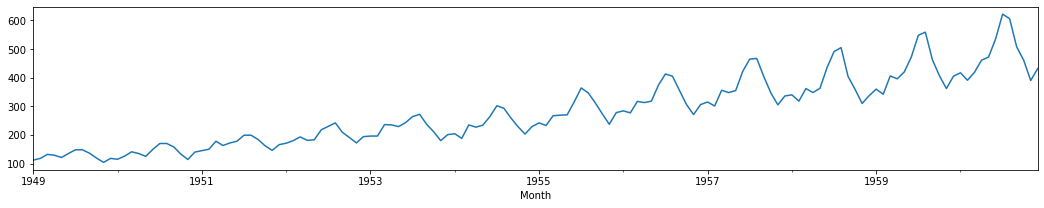

In [6]:
# basic plot
s.plot();

## Punto 1

In [7]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 144
Training Observations: 94
Testing Observations: 49


## Punto 2

In [8]:
def model_persistence(x):
    return x

In [9]:
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.811


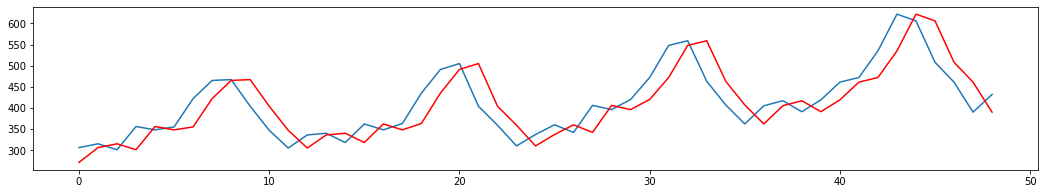

In [10]:
plt.plot(test_y[:100])
plt.plot(predictions[0:100], color='red')
plt.show()

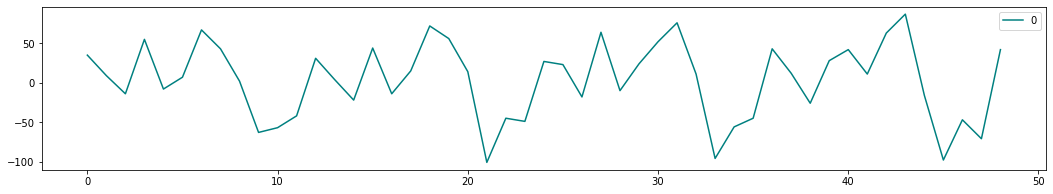

In [11]:
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.plot(color='teal');

In [12]:
residuals.describe()

,0
count,49.00
mean,3.29
std,48.19
min,-101.00
25%,-26.00
50%,11.00
75%,42.00
max,87.00


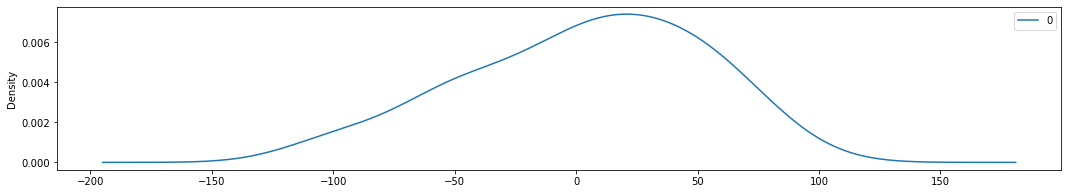

In [13]:
residuals.plot(kind='kde');

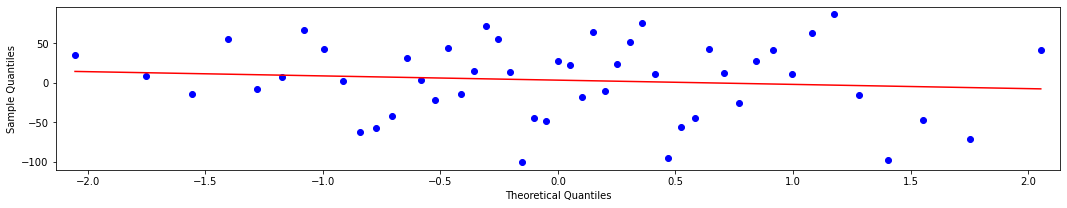

In [14]:
qqplot(residuals, line='r')
plt.show()

Nuestros resultados residuales, al tener las estadísticas descriptivas y haciendo enfoque en error medio, vemos de que el valor no es muy cercano a cero (3.29), y sugiere que hay un sesgo fuerte en nuestros pronósticos. Es decir, debemos establecer correcciones a nuestro modelo o probar otros.

Por otro lado, podemos ver que nuestra gráfica de densidad del error tiene una similitud a una distribución gaussiana (normal). Sin embargo, al tener nuestro qqplot vemos que las distribuciones en realidad difieren bastante. Observe que nuestra RMSE es bastante grande, por lo tanto podemos decir que nuestro modelo no se está ajustando de manera óptima a los datos.

## Punto 3

In [15]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [16]:
# train autoregression
model = AR(train)
model_fit = model.fit()

In [17]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 12
Coefficients: [ 0.59140795  0.48803259 -0.25522017  0.17089236 -0.21099252  0.21241271
 -0.11387109  0.09605027 -0.21578348  0.22833585 -0.1966301   0.31994813
  0.57585993]


In [18]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [19]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

predicted=306.978357, expected=306.000000
predicted=326.242172, expected=315.000000
predicted=323.466064, expected=301.000000
predicted=350.387519, expected=356.000000
predicted=352.194565, expected=348.000000
predicted=370.678221, expected=355.000000
predicted=426.513059, expected=422.000000


In [20]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.633


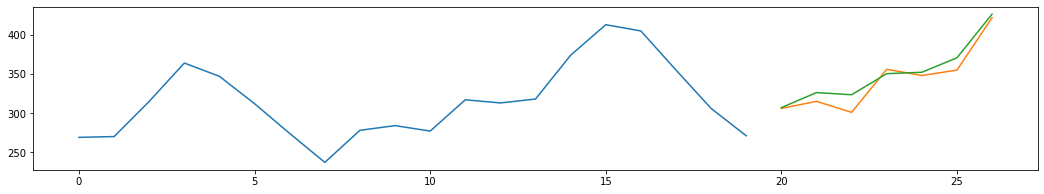

In [21]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]]);

**Sí es mejor**, pues nuestra métrica RMSE es mucho menor a la que obtuvimos en el modelo persistente, significando que nuestros datos se ajustan mejor al modelo.

## Punto 4

### Modelamiento del error residual con autoregresión y corrección de predicciones

In [22]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
df.head()

,t,t+1
0,nan,112
1,112.00,118
2,118.00,132
3,132.00,129
4,129.00,121


In [23]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [24]:
# persistence model on training set
train_pred = [x for x in train_X]

In [25]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [26]:
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [27]:
print('Lag=%d, Coef=%s' % (window, coef))

Lag=12, Coef=[ 6.73096433 -0.15858052 -0.24789727 -0.19155056 -0.26996064 -0.17048485
 -0.23497743 -0.21772851 -0.30489576 -0.18296949 -0.30251053 -0.11015227
  0.74668214]


In [28]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]

    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    #print('predicted=%f, expected=%f' % (yhat, test_y[t]))

# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [29]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 13.897


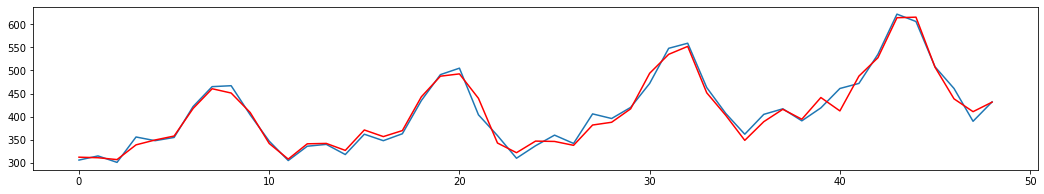

In [30]:
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red');

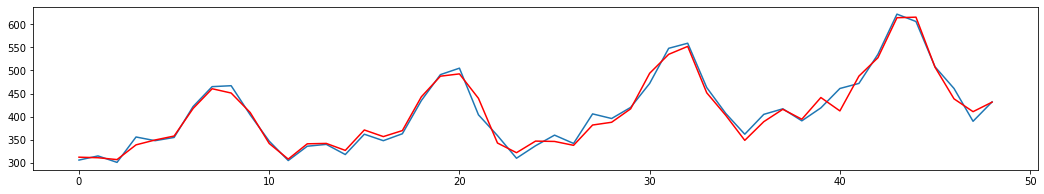

In [31]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

Podemos observar un grandísimo mejoramiento en nuestra predicción en comparación con el modelo de persistencia solo. En este caso, tenemos un RMSE de 13.897, el cual es muchísimo mejor al RMSE de 47.81 que obtuvimos anteriormente.

## Punto 5

### Modelo ARIMA

In [40]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [41]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [42]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 45.176


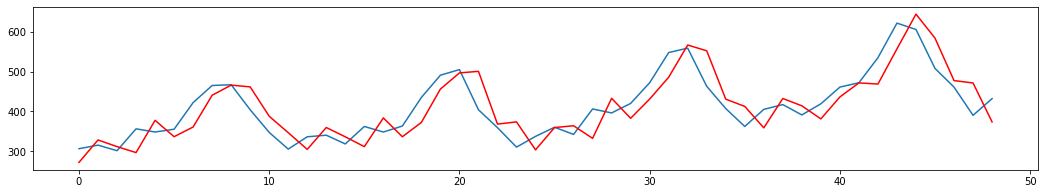

In [43]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

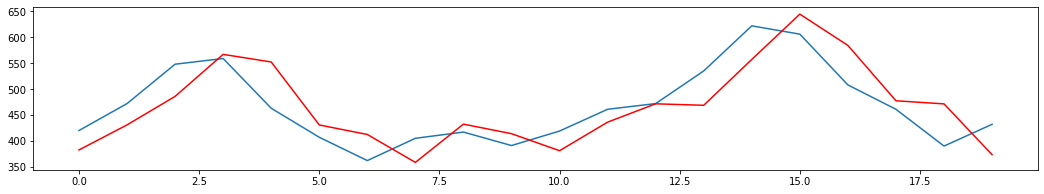

In [44]:
# zoom plot
plt.plot(test_y[-20:])
plt.plot(predictions[-20:], color='red')
plt.show()

Utilizando `p=2`, `d=1`, `q=0` obtenemos una métrica RMSE no muy buena y similar a la que obtuvimos con el modelo de persistencia solo. En este caso, nuestro modelamiento a través de autoregresión, modelando los residuales, sigue siendo significativamente mejor.

## Punto 6 (opcional)

In [37]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [38]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [39]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

evaluate_models(s.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=180.036
ARIMA(0, 0, 1) RMSE=97.759
ARIMA(0, 1, 0) RMSE=47.913
ARIMA(0, 1, 1) RMSE=45.258
ARIMA(0, 1, 2) RMSE=46.804
ARIMA(0, 2, 0) RMSE=56.063
ARIMA(0, 2, 1) RMSE=48.642
ARIMA(0, 2, 2) RMSE=45.828
ARIMA(1, 0, 0) RMSE=48.329
ARIMA(1, 0, 1) RMSE=45.622
ARIMA(1, 0, 2) RMSE=46.690
ARIMA(1, 1, 0) RMSE=45.806
ARIMA(1, 1, 1) RMSE=45.793
ARIMA(1, 2, 0) RMSE=55.604
ARIMA(2, 0, 0) RMSE=46.027
ARIMA(2, 0, 1) RMSE=45.155
ARIMA(2, 1, 0) RMSE=45.176
ARIMA(2, 1, 1) RMSE=39.140
ARIMA(2, 1, 2) RMSE=40.094
ARIMA(2, 2, 0) RMSE=54.738
ARIMA(2, 2, 2) RMSE=45.366
Best ARIMA(2, 1, 1) RMSE=39.140


Obtuvimos que <code>ARIMA(2, 1, 1)</code> es el de mejor comportamiento y lo seleccionamos para nuestro modelo.

In [55]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [56]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [57]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 39.140


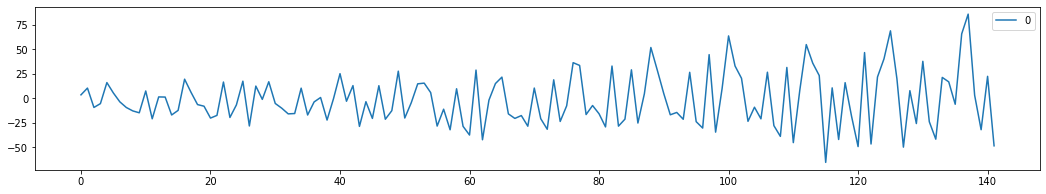

In [58]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

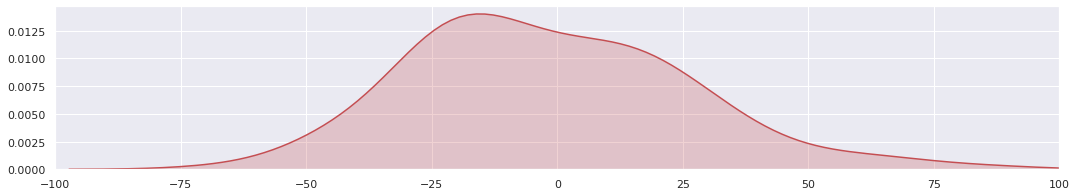

In [61]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-100, 100));

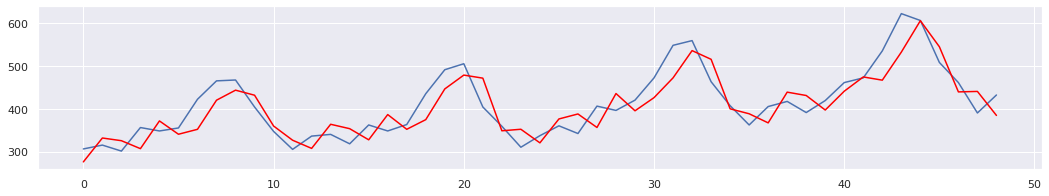

In [62]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

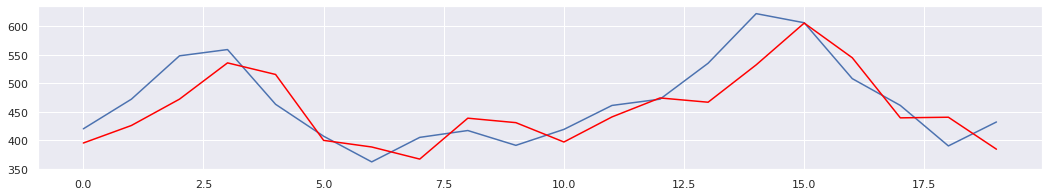

In [64]:
# zoom plot
plt.plot(test_y[-20:])
plt.plot(predictions[-20:], color='red')
plt.show()

Revisamos la parte que estábamos evaluando:

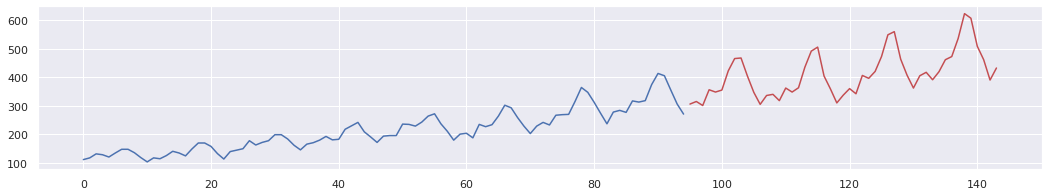

In [65]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');